# Fibroblast gene Repression Analysis

Examine repression of fibroblast genes in different clusters.

In [49]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(scales)
library(Matrix)
library(GenomicRanges)
library(dplyr)
library(rtracklayer)
library(matrixStats)
library(ggforce)

## Load Data

In [2]:
rna = readRDS("../../analysis/20220606_Multiome_RNA_Seurat/sessions/20220608_n7378/seurat.rds")

In [3]:
# Metadata file for scATAC + Multiome ATAC
atac_metaData = read.table("../../analysis/20220609_Multiome_SnapATAC/sessions/20220612_n13525/metadata.w.transfer.cluster.tsv", header = T, stringsAsFactor=F)
# atac_metaData = read.table("../20220609_Multiome_SnapATAC/metadata.no.harmony.tsv", header = T, stringsAsFactor=F)
rownames(atac_metaData) = paste(atac_metaData$sample, atac_metaData$barcode, sep='_')
atac_metaData$cells = rownames(atac_metaData)
dim(atac_metaData)
head(atac_metaData, 5)

[1] 13525    12

,barcode,TN,UM,PP,UQ,CM,cluster,umap1,umap2,sample,cells,transfered_cluster
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>
D1M_AAAAAAAAAAACATGCTATTAGCC,AAAAAAAAAAACATGCTATTAGCC,6736,6736,6736,6729,373,3,-0.4031222,-3.454888,D1M,D1M_AAAAAAAAAAACATGCTATTAGCC,3
D1M_AAAAAAAAAAACATGCTCACCCTC,AAAAAAAAAAACATGCTCACCCTC,28369,28369,28369,28339,2447,5,2.6643078,-3.955240,D1M,D1M_AAAAAAAAAAACATGCTCACCCTC,3
D1M_AAAAAAAAAAACATGCTTGAGAAC,AAAAAAAAAAACATGCTTGAGAAC,28635,28635,28635,28609,2201,1,-0.2071755,2.688192,D1M,D1M_AAAAAAAAAAACATGCTTGAGAAC,15
D1M_AAAAAAAAAAACCATGAACCTTGT,AAAAAAAAAAACCATGAACCTTGT,33869,33869,33869,33838,3018,5,3.1269215,-4.609105,D1M,D1M_AAAAAAAAAAACCATGAACCTTGT,3
D1M_AAAAAAAAAAACCATGAGCTTAAA,AAAAAAAAAAACCATGAGCTTAAA,18885,18885,18885,18867,1514,1,-0.1988264,1.998739,D1M,D1M_AAAAAAAAAAACCATGAGCTTAAA,15


In [4]:
atac_metaData_multiome_filt = atac_metaData[atac_metaData$sample!="D2", ]
dim(atac_metaData_multiome_filt)

[1] 7378   12

In [5]:
atac_to_rna_bc_map = read.table("/srv/scratch/surag/scMultiome-reprog/ATAC.RNA.bc.map.tsv", sep='\t', 
                                header=F, stringsAsFactors=F)
colnames(atac_to_rna_bc_map) = c("ATAC", "RNA")
rownames(atac_to_rna_bc_map) = paste("AAAAAAAA", atac_to_rna_bc_map$ATAC, sep='')
head(atac_to_rna_bc_map)

,ATAC,RNA
,<chr>,<chr>
AAAAAAAAGTAACACACCCGCTGT,GTAACACACCCGCTGT,AAACAGCCAAACAACA
AAAAAAAAAAGAACAACCCGCTGT,AAGAACAACCCGCTGT,AAACAGCCAAACATAG
AAAAAAAAGCCTGTTACCCGCTGT,GCCTGTTACCCGCTGT,AAACAGCCAAACCCTA
AAAAAAAATTCGCGCACCCGCTGT,TTCGCGCACCCGCTGT,AAACAGCCAAACCTAT
AAAAAAAAATGGAGGACCCGCTGT,ATGGAGGACCCGCTGT,AAACAGCCAAACCTTG
AAAAAAAAAACCATGACCCGCTGT,AACCATGACCCGCTGT,AAACAGCCAAACGCGA


In [6]:
all(atac_metaData_multiome_filt$barcode %in% rownames(atac_to_rna_bc_map))

[1] TRUE

In [7]:
head(atac_metaData_multiome_filt)

,barcode,TN,UM,PP,UQ,CM,cluster,umap1,umap2,sample,cells,transfered_cluster
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>
D1M_AAAAAAAAAAACATGCTATTAGCC,AAAAAAAAAAACATGCTATTAGCC,6736,6736,6736,6729,373,3,-0.4031222,-3.454888,D1M,D1M_AAAAAAAAAAACATGCTATTAGCC,3
D1M_AAAAAAAAAAACATGCTCACCCTC,AAAAAAAAAAACATGCTCACCCTC,28369,28369,28369,28339,2447,5,2.6643078,-3.955240,D1M,D1M_AAAAAAAAAAACATGCTCACCCTC,3
D1M_AAAAAAAAAAACATGCTTGAGAAC,AAAAAAAAAAACATGCTTGAGAAC,28635,28635,28635,28609,2201,1,-0.2071755,2.688192,D1M,D1M_AAAAAAAAAAACATGCTTGAGAAC,15
D1M_AAAAAAAAAAACCATGAACCTTGT,AAAAAAAAAAACCATGAACCTTGT,33869,33869,33869,33838,3018,5,3.1269215,-4.609105,D1M,D1M_AAAAAAAAAAACCATGAACCTTGT,3
D1M_AAAAAAAAAAACCATGAGCTTAAA,AAAAAAAAAAACCATGAGCTTAAA,18885,18885,18885,18867,1514,1,-0.1988264,1.998739,D1M,D1M_AAAAAAAAAAACCATGAGCTTAAA,15
D1M_AAAAAAAAAAACCATGATATAGGC,AAAAAAAAAAACCATGATATAGGC,12385,12385,12385,12370,1282,5,1.7942727,-3.712197,D1M,D1M_AAAAAAAAAAACCATGATATAGGC,3


In [8]:
rna_bc_order = paste(atac_to_rna_bc_map[atac_metaData_multiome_filt$barcode, "RNA"], ifelse(atac_metaData_multiome_filt$sample=="D1M", 1, 2), sep='-')
head(rna_bc_order)

[1] "CAAACCGTCCAATAGC-1" "TACTTCGTCCAATAGC-1" "TTTGTGTTCCAATAGC-1"
[4] "CTCTCACAGATAAAGC-1" "GGCCTTAAGATAAAGC-1" "CCAAGTTAGATAAAGC-1"

In [9]:
all(rna_bc_order %in% colnames(rna))

[1] TRUE

In [662]:
# fibr_genes = as.character(unlist(read.table("../20200828_RNA_Seurat/lists/fibroblast.genes.txt")$V1))
# fibr_genes = fibr_genes[fibr_genes %in% rownames(rna)]
# length(fibr_genes)

In [11]:
fibr_genes = as.character(unlist(read.table("../../analysis/20220612_Multiome_Repression/fibr_ipsc_diff.txt")$V1))
length(fibr_genes)
fibr_genes = fibr_genes[fibr_genes %in% rownames(rna)]
length(fibr_genes)

[1] 1113

[1] 1113

In [12]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config$label = paste(cluster_config$new_cluster, cluster_config$description, sep=' - ')
cluster_config

cluster,colour,description,new_cluster,label
<int>,<fct>,<fct>,<int>,<chr>
1,#B03743,Fibroblast,1,1 - Fibroblast
2,#E85F6D,Fibroblast-like,3,3 - Fibroblast-like
3,#7C2730,Fibroblast-like,2,2 - Fibroblast-like
4,#F0A118,Intermediate,12,12 - Intermediate
5,#78A824,Pre-iPSC,13,13 - Pre-iPSC
6,#A6D854,Pre-iPSC,14,14 - Pre-iPSC
7,#F01D35,Fibroblast-like,5,5 - Fibroblast-like
8,#13C4A3,iPSC,15,15 - iPSC
9,#406614,Partially-reprogrammed,10,10 - Partially-reprogrammed


In [261]:
day_config = read.table("../configs/multiome_day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=c("D1M", "D2M", "D2"))
rownames(day_config) = day_config$day
day_config

,day,colour
,<fct>,<chr>
D1M,D1M,#53a548
D2M,D2M,#6E3B4E
D2,D2,#FF70A6


## Expression Plots

In [319]:
get_plot <- function(gene, selection=NULL, min_quant=0.02) {
    cur_gene = as.vector(rna[['RNA']][gene, rna_bc_order])
    
    plot_vals(cur_gene, selection, min_quant) + ggtitle(sub("-2[0-9]+", "",gene)) 
}

plot_vals <- function(vals, selection=NULL, min_quant=0.02) {
    
    if (is.null(selection)) {
        selection = seq(length(vals))
    }
    df = data.frame(umap1=atac_metaData_multiome_filt$umap1[selection], 
                    umap2=atac_metaData_multiome_filt$umap2[selection],
                    expr=vals[selection])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]


    expr_plot <- ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=.8, aes(x=umap1 , y=umap2, col=expr)) +
    scale_color_viridis_c(option = "C", name="Log2\nExpr", 
                         limits=c(quantile(vals, min_quant),quantile(vals, 0.98)), oob=squish) +
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        coord_fixed()    
    
    expr_plot
}

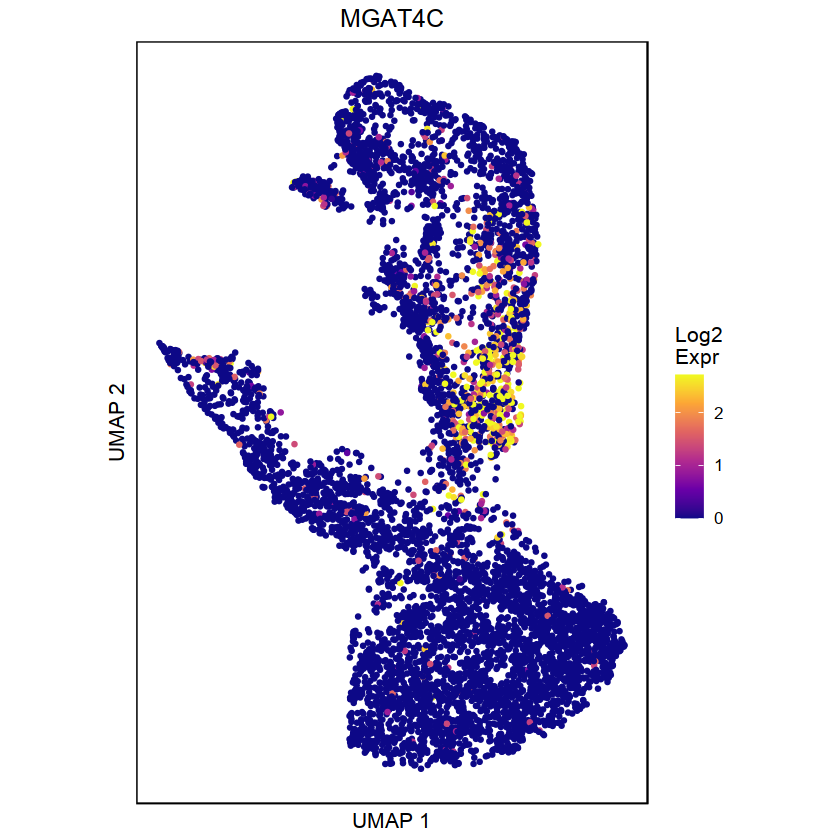

In [320]:
options(repr.plot.width = 7, repr.plot.height = 7)

get_plot("MGAT4C")

In [15]:
GENE="COL1A1"
mean(as.vector(rna[['RNA']][GENE, rna_bc_order])[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==11)])
mean(as.vector(rna[['RNA']][GENE, rna_bc_order])[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==15)])
mean(as.vector(rna[['RNA']][GENE, rna_bc_order])[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==13)])
mean(as.vector(rna[['RNA']][GENE, rna_bc_order])[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==3)])

[1] 0.8175369

[1] 0.8694299

[1] 1.825705

[1] 2.264284

In [321]:
mean_fibr_scaled = as.vector(colMeans(rna@assays$RNA@scale.data[fibr_genes, rna_bc_order]))
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==11)])
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==15)])
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==13)])
mean(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==3)])

[1] -0.07650123

[1] -0.05975318

[1] 0.009800309

[1] 0.04655874

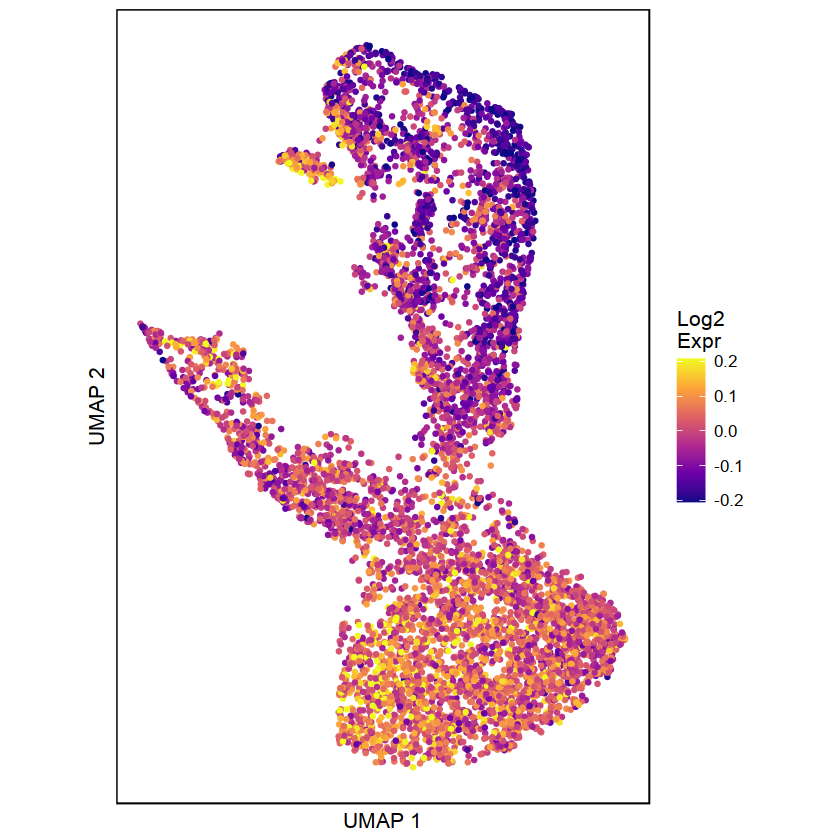

In [322]:
options(repr.plot.width = 7, repr.plot.height = 7)
plot_vals(mean_fibr_scaled) #, selection=atac_metaData_multiome_filt$sample=="D2M")

In [25]:
table(atac_metaData_multiome_filt$transfered_cluster)


   2    3   11   13   15 
  28 3142 1563 1429 1216 

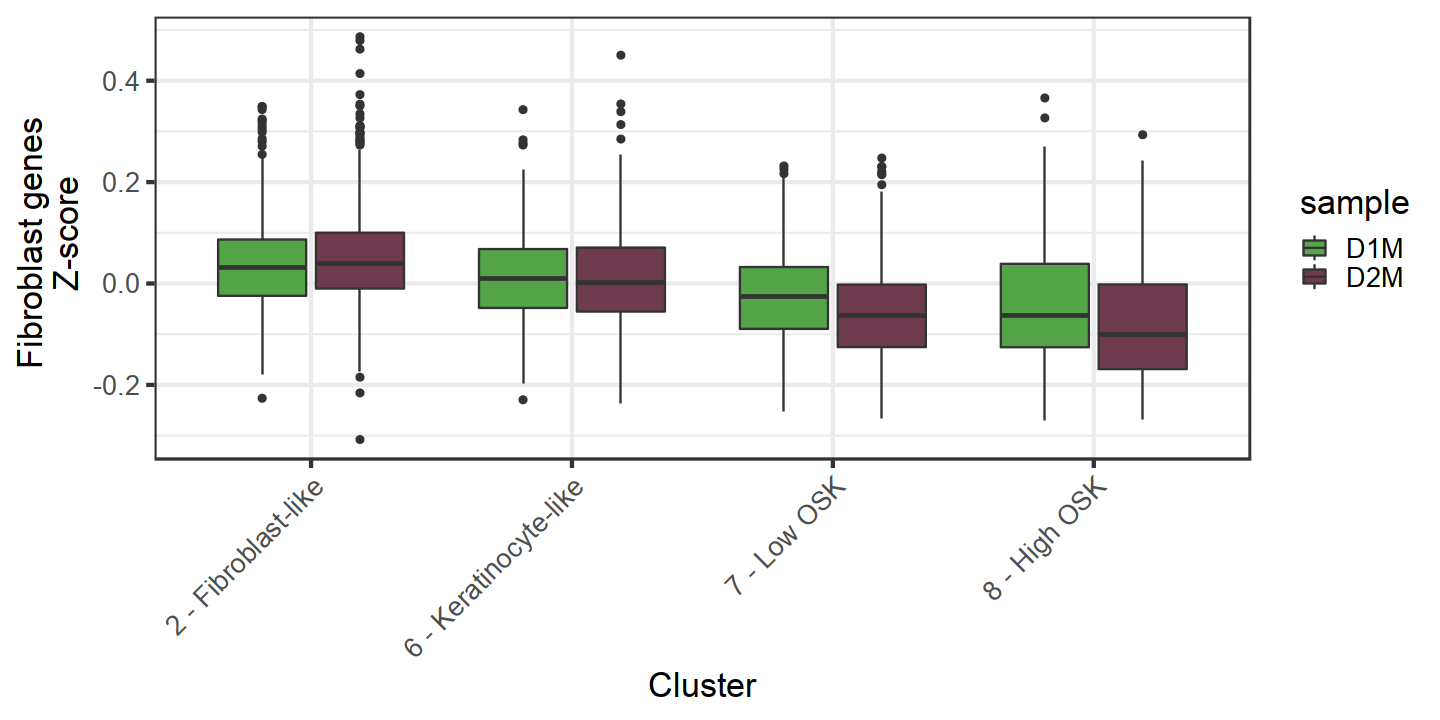

In [271]:
options(repr.plot.width = 12, repr.plot.height = 6)

# removing 2 since few cells
subset = atac_metaData_multiome_filt$transfered_cluster != 2

fibr_expr_plot = ggplot(data.frame(val=mean_fibr_scaled[subset],
                  clst=as.character(cluster_config[atac_metaData_multiome_filt$transfered_cluster, "label"][subset]),
                  sample=atac_metaData_multiome_filt$sample[subset])) +
#            clst=paste(atac_metaData_multiome_filt$sample,
#                       atac_metaData_multiome_filt$transfered_cluster, sep='-'))) +
geom_boxplot(aes(x=factor(clst, levels=as.character(cluster_config[c(2,3,13,15,11), "label"])), 
                 y=val, fill=sample)) +
scale_fill_manual(values=day_config$colour[1:2]) + 
#            position=position_dodge(0.9)) +
xlab("Cluster") +
ylab("Fibroblast genes \n Z-score") +
theme_bw(base_size=20) +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

fibr_expr_plot

In [270]:
ggsave("./subfigs/FibrExprGroup.pdf", fibr_expr_plot, height=6, width=12, useDingbats=F)

In [20]:
wilcox.test(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D1M")&(atac_metaData_multiome_filt$transfered_cluster==11)],
           mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==11)])


	Wilcoxon rank sum test with continuity correction

data:  mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D1M") &  and mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D2M") &     (atac_metaData_multiome_filt$transfered_cluster == 11)] and     (atac_metaData_multiome_filt$transfered_cluster == 11)]
W = 362756, p-value = 9.485e-11
alternative hypothesis: true location shift is not equal to 0


In [255]:
wilcox.test(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==15)],
           mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==11)])


	Wilcoxon rank sum test with continuity correction

data:  mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D2M") &  and mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D2M") &     (atac_metaData_multiome_filt$transfered_cluster == 15)] and     (atac_metaData_multiome_filt$transfered_cluster == 11)]
W = 339560, p-value = 3.813e-06
alternative hypothesis: true location shift is not equal to 0


In [257]:
wilcox.test(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D1M")&(atac_metaData_multiome_filt$transfered_cluster==15)],
           mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D1M")&(atac_metaData_multiome_filt$transfered_cluster==11)])


	Wilcoxon rank sum test with continuity correction

data:  mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D1M") &  and mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D1M") &     (atac_metaData_multiome_filt$transfered_cluster == 15)] and     (atac_metaData_multiome_filt$transfered_cluster == 11)]
W = 200996, p-value = 0.0004523
alternative hypothesis: true location shift is not equal to 0


In [259]:
wilcox.test(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==13)],
           mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==3)])


	Wilcoxon rank sum test with continuity correction

data:  mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D2M") &  and mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D2M") &     (atac_metaData_multiome_filt$transfered_cluster == 13)] and     (atac_metaData_multiome_filt$transfered_cluster == 3)]
W = 549930, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [256]:
wilcox.test(mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==3)],
           mean_fibr_scaled[(atac_metaData_multiome_filt$sample=="D2M")&(atac_metaData_multiome_filt$transfered_cluster==11)])


	Wilcoxon rank sum test with continuity correction

data:  mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D2M") &  and mean_fibr_scaled[(atac_metaData_multiome_filt$sample == "D2M") &     (atac_metaData_multiome_filt$transfered_cluster == 3)] and     (atac_metaData_multiome_filt$transfered_cluster == 11)]
W = 1151404, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [21]:
day_clst = factor(paste(atac_metaData_multiome_filt$sample, 
             atac_metaData_multiome_filt$transfered_cluster, sep='-'), 
       levels = c(paste("D1M", c(2,3,13,15,11), sep='-'), paste("D2M", c(2,3,13,15,11), sep='-')))
rna_tpm = as.matrix(rna@assays$RNA@counts[, rna_bc_order] %*% sparseMatrix(i=seq(ncol(rna)), j=as.integer(day_clst)))
colnames(rna_tpm) = levels(day_clst)
rna_tpm = 1e6*t(t(rna_tpm)/colSums(rna_tpm))

In [30]:
rna_tpm[c("COL1A1", "VIM", "FN1", "JUN", "JUNB", "JUND", "FOS", "FOSL2", "FOSL1", "MAP2", "JAKMIP2", "KRT14", "KRT16", "HBA1"), ]

,D1M-2,D1M-3,D1M-13,D1M-15,D1M-11,D2M-2,D2M-3,D2M-13,D2M-15,D2M-11
COL1A1,676.52896,556.1031883,609.4479701,302.0453104,243.4274586,1393.64729,1356.7613871,854.171964,366.9970095,377.861615
VIM,1758.97528,1547.5021610,1347.2831812,1403.9930300,1002.5784313,1930.78218,1505.9054960,935.456511,1129.9824278,723.059358
FN1,1578.56756,1081.9603062,744.8808523,642.3526944,617.7879726,1117.82126,1062.4910602,523.012695,282.7514134,401.122251
JUN,0.00000,43.3350131,34.8367818,24.7578123,18.9973992,43.55148,39.8574774,19.157974,16.0305385,15.342122
JUNB,0.00000,12.5583099,20.3540748,9.9031249,6.1462174,14.51716,15.1072697,15.052694,6.1393552,6.928700
JUND,45.10193,17.8646380,23.4854709,16.6552556,11.9199368,58.06864,24.2680608,36.400151,15.6894632,19.796286
FOS,0.00000,0.3537552,0.3914245,0.4501420,0.9312451,0.00000,0.1607156,0.821056,0.3410753,1.484721
FOSL2,45.10193,36.7905417,36.7939044,24.7578123,25.3298656,43.55148,33.4288520,36.947522,11.9376351,20.291193
FOSL1,135.30579,241.9685628,236.8118317,142.6950274,106.1619368,159.68875,200.2516807,131.368966,114.6012966,86.361299
MAP2,45.10193,54.1245470,93.1590346,600.4894845,918.5801269,14.51716,54.0004532,134.105819,402.8099146,1333.774791


In [275]:
# removing 2 since few cells
subset = atac_metaData_multiome_filt$transfered_cluster != 2

cur = data.frame(val=as.vector(rna[['RNA']]["COL1A1", rna_bc_order])[subset],
                  clst=as.character(cluster_config[atac_metaData_multiome_filt$transfered_cluster, "label"])[subset],
                  sample=atac_metaData_multiome_filt$sample[subset]
                )
cur$isnonzero = cur$val >0 

cur %>% group_by(clst, sample) %>% summarize(frac_nonzero = mean(isnonzero), nonzero_mean=sum(val)/sum(isnonzero)) 

`summarise()` regrouping output by 'clst' (override with `.groups` argument)



clst,sample,frac_nonzero,nonzero_mean
<fct>,<fct>,<dbl>,<dbl>
2 - Fibroblast-like,D1M,0.7709091,1.950009
2 - Fibroblast-like,D2M,0.8936050,2.533876
6 - Keratinocyte-like,D1M,0.8115702,1.977390
6 - Keratinocyte-like,D2M,0.8179612,2.232020
7 - Low OSK,D1M,0.5483193,1.702806
7 - Low OSK,D2M,0.4459459,1.949631
8 - High OSK,D1M,0.4874172,1.453804
8 - High OSK,D2M,0.4344059,1.881965


In [101]:
plot_gene_expr <- function(gene) {
    # removing 2 since few cells
    subset = atac_metaData_multiome_filt$transfered_cluster != 2

    cur = data.frame(val=as.vector(rna@assays$RNA@data[gene, rna_bc_order])[subset],
                      clst=as.character(cluster_config[atac_metaData_multiome_filt$transfered_cluster, "label"])[subset],
                      sample=atac_metaData_multiome_filt$sample[subset]
                    )
    cur$isnonzero = cur$val >0 

    df = cur %>% group_by(clst, sample) %>% summarize(frac_nonzero = mean(isnonzero), nonzero_mean=sum(val)/sum(isnonzero))
    
    d1 = ggplot(df %>% filter(sample=="D1M")) +
           geom_circle(aes(x0=as.numeric(clst), y0=1, r=0.5*frac_nonzero, fill=nonzero_mean), color="white") +
            theme_bw(base_size=16) +
            scale_fill_gradient(low='white', high='navy',
                               limits=c(0.5, max(df$nonzero_mean)))+ 
            theme(axis.text.y=element_blank(),
                 axis.ticks.y = element_blank(),
                  axis.text.x=element_blank(),
                 axis.ticks.x = element_blank(),
                  axis.title.x=element_blank(),
                  axis.title.y=element_blank(),
                  panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank()
                 ) +
            coord_fixed()
    
    d2 = ggplot(df %>% filter(sample=="D2M")) +
           geom_circle(aes(x0=as.numeric(clst), y0=1, r=0.5*frac_nonzero, fill=nonzero_mean), color="white") +
            theme_bw(base_size=16) +
            scale_fill_gradient(low='white', high='navy',
                               limits=c(0.5, max(df$nonzero_mean)))+ 
            theme(axis.text.y=element_blank(),
                 axis.ticks.y = element_blank(),
                  axis.text.x=element_blank(),
                 axis.ticks.x = element_blank(),
                  axis.title.x=element_blank(),
                  axis.title.y=element_blank(),
                  panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank()
                 ) +
            coord_fixed()
    
    d1 / d2
}

In [312]:
plot_gene_expr_multiple <- function(genes) {
    # removing 2 since few cells
    subset = atac_metaData_multiome_filt$transfered_cluster != 2
    
    dfs = list()
    
    i = 1
    for (x in genes) {
        cur = data.frame(val=as.vector(rna@assays$RNA@scale.data[x, rna_bc_order])[subset],
                         is_expr = as.vector(rna@assays$RNA@data[x, rna_bc_order])[subset] > 0,
                      clst=as.character(cluster_config[atac_metaData_multiome_filt$transfered_cluster, "label"])[subset],
                      sample=atac_metaData_multiome_filt$sample[subset]
                    )

        df = cur %>% group_by(clst, sample) %>% summarize(frac_nonzero = mean(is_expr), nonzero_mean=median(val[is_expr]))
        df$gene = x 
        
        dfs[[i]] = df
        
        i = i+1
    }
    
    dfs = do.call(rbind, dfs)
    dfs$x = paste(as.character(dfs$clst), as.character(dfs$sample), sep='-')
    
    # adding this line to move to legend as this plot doesn't generate legend by default
    i = 1
    for (x in c(.75, .5, .25)) {
            dfs[nrow(dfs) + 1,] = dfs[nrow(dfs), ]
        dfs[nrow(dfs), "gene"] = "SCALE"
        dfs[nrow(dfs), "x"] = levels(factor(dfs$x))[i]
        dfs[nrow(dfs), "frac_nonzero"] = x
        dfs[nrow(dfs), "nonzero_mean"] = max(dfs$nonzero_mean)
        i=i+1
    }
        
    ggplot(dfs) +
           geom_circle(aes(x0=as.numeric(factor(x)), 
                           y0=as.numeric(factor(gene, levels=c(rev(genes), "SCALE"))), 
                           r=0.4*frac_nonzero, 
                           fill=nonzero_mean), 
                       color="white",
                      show.legend=T) +
            theme_bw(base_size=16) +
            scale_fill_gradient(low='grey', high='navy', limits=c(-.2, 1), oob=squish) +
#                                limits=c(0.5, max(dfs$nonzero_mean)))+ 
            theme(
                axis.text.y=element_text(),
#                  axis.ticks.y = element_blank(),
                  axis.text.x=element_text(angle=45, hjust=1, vjust=1),
#                  axis.ticks.x = element_blank(),
                  axis.title.x=element_blank(),
                  axis.title.y=element_blank(),
                  panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank()
                 ) +
        scale_y_continuous(breaks=seq(length(genes)+1), labels=c(rev(genes), "SCALE")) +
        scale_x_continuous(breaks=seq(length(unique(dfs$x))), labels=levels(factor(dfs$x))) +
            coord_fixed()

}

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)



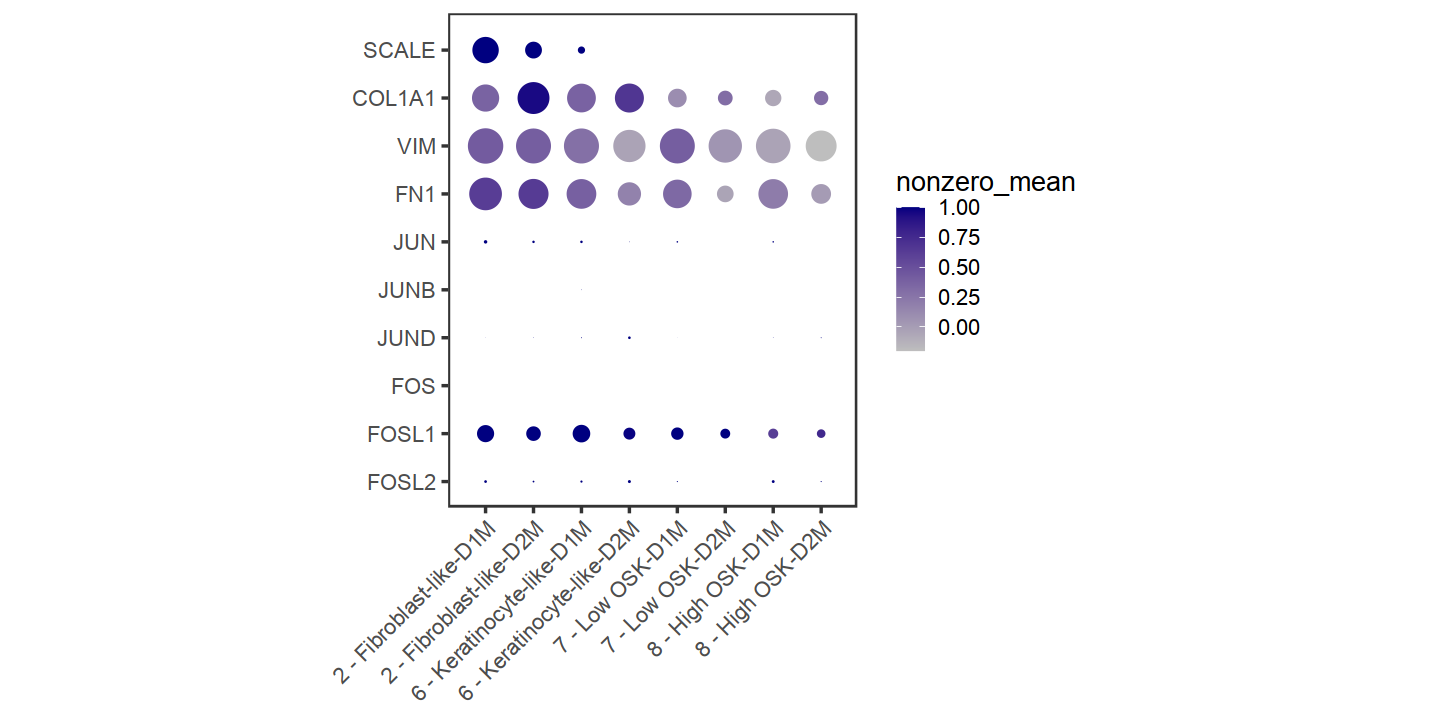

In [313]:
plot_gene_expr_multiple(c("COL1A1", "VIM", "FN1", "JUN", "JUNB", "JUND", "FOS", "FOSL1", "FOSL2"))

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)

`summarise()` regrouping output by 'clst' (override with `.groups` argument)



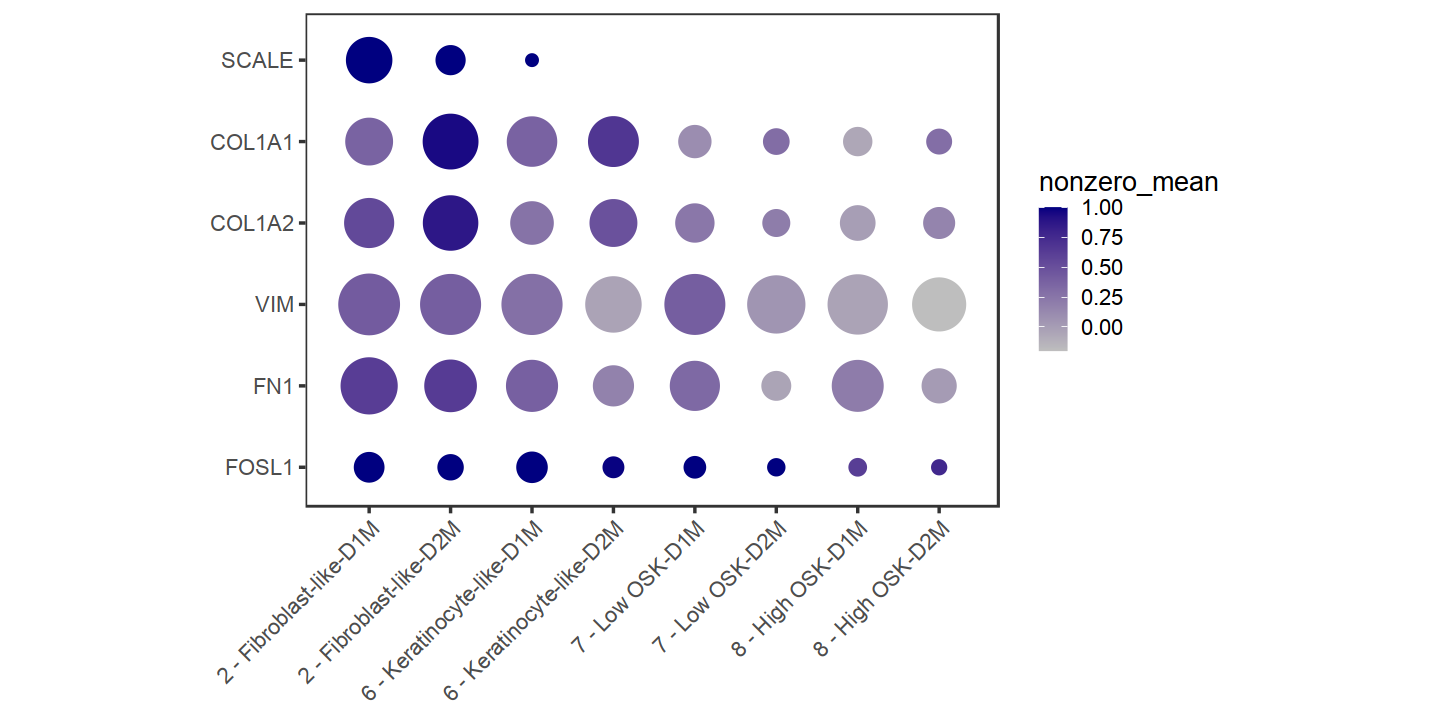

In [316]:
options(repr.plot.width = 12, repr.plot.height = 6)

fibr_individual_plot = plot_gene_expr_multiple(c("COL1A1", "COL1A2", "VIM", "FN1", "FOSL1"))
fibr_individual_plot

In [308]:
ggsave("./subfigs/FibrExprIndividual.pdf", fibr_individual_plot, height=6, width=12, useDingbats=F)

---

In [213]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggforce_0.3.2        matrixStats_0.56.0   rtracklayer_1.46.0  
 [4] dplyr_1.0.2          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [7] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
[10] Matrix_1.2-18        scales_1.1.0         patchwork_1.0.0     
[13